In [1]:
import numpy as np
import pandas as pd

import scipy as sp
from scipy import linalg as la
from scipy import optimize
from scipy import stats
from scipy.stats import chisquare

import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
file = 'SouthCalifornia-1982-2011_Physics-of-Data.dat'
data = np.genfromtxt(file,
                     dtype=None,
                     delimiter=' ')
data.shape

(110271,)

In [3]:
df = pd.DataFrame(data)
df.columns = ['event', 'prev_event', 'time', 'magnitude', 'x', 'y', 'z']

# 0 - Understanding data

First of all we took a look at the dataset.

In [4]:
df.head()

,event,prev_event,time,magnitude,x,y,z
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546


In [5]:
# we can see that the range of magnitudes is [2,7.3] 
# and that the measurement of time starts from 0 with the first event
df.describe()

,event,prev_event,time,magnitude,x,y,z
count,110271.000000,110271.000000,1.102710e+05,110271.000000,1.102710e+05,1.102710e+05,1.102710e+05
mean,55135.000000,35859.277625,4.262426e+08,2.457920,-2.388225e+06,-4.691072e+06,3.562612e+06
std,31832.640104,36365.001297,2.598605e+08,0.438374,8.878019e+04,1.237294e+05,1.271897e+05
min,0.000000,-1.000000,0.000000e+00,2.000000,-2.770239e+06,-5.020849e+06,3.186133e+06
25%,27567.500000,-1.000000,2.115783e+08,2.140000,-2.421620e+06,-4.801152e+06,3.458838e+06
50%,55135.000000,28462.000000,3.551023e+08,2.340000,-2.361829e+06,-4.699729e+06,3.564367e+06
75%,82702.500000,66972.000000,5.952398e+08,2.640000,-2.329898e+06,-4.615062e+06,3.634552e+06
max,110270.000000,110250.000000,9.305667e+08,7.300000,-1.998294e+06,-4.268289e+06,3.876120e+06


In [6]:
# not all the greatest earthquakes are without ancestors (we shall call them 'prime events')
df[df['magnitude']>6].sort_values(by = 'magnitude', ascending = False)

,event,prev_event,time,magnitude,x,y,z
39805,39805,39804,3.309144e+08,7.30,-2341818,-4710335,3575181
100065,100065,100062,8.915162e+08,7.20,-2294542,-4855348,3390238
75422,75422,75419,5.612489e+08,7.10,-2316706,-4693410,3609984
58367,58367,-1,3.799916e+08,6.70,-2508327,-4610300,3567642
22089,22089,21867,1.859399e+08,6.60,-2322573,-4795291,3462353
89331,89331,-1,6.932159e+08,6.48,-2662869,-4420508,3708948
39859,39859,39858,3.309257e+08,6.30,-2373276,-4692488,3573922
21867,21867,21866,1.858990e+08,6.20,-2316585,-4796535,3470023
37455,37455,37449,3.251864e+08,6.10,-2335795,-4723356,3549940
55532,55532,-1,3.588626e+08,6.10,-2364815,-4481227,3839436


# 1 - Data visualization

## 1.1 - Time distribution

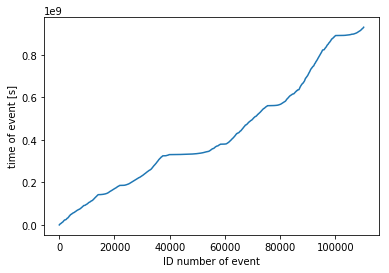

In [7]:
# just a routine look at the time distribution and time scale of the dataset 
%matplotlib inline

plt.plot(df['event'], df['time'])
plt.xlabel('ID number of event')
plt.ylabel('time of event [s]')
plt.show()

## 1.2 - Magnitude distribution

In [8]:
def my_expon(x, No, alpha):
    return No*np.exp(-alpha*x)

def my_log_expon(x, Q, alpha):
    return -alpha*x + Q

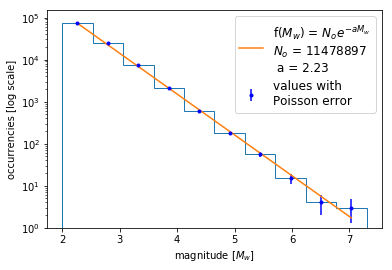

In [9]:
# here we can see how the magnitude is distributed as exp(-m)
n, bins, _ = plt.hist(df['magnitude'], log = True, histtype = 'step')
bin_centers = (bins[1:] + bins[:-1])/2
plt.errorbar(bin_centers, n, np.sqrt(n), fmt = '.b', label = 'values with \nPoisson error')

params1, _ = optimize.curve_fit(my_log_expon, bin_centers, np.log(n))
[Q, alpha] = params1
No = int(np.exp(Q))
plt.plot(bin_centers, my_expon(bin_centers, No, alpha), 
         label = 'f($M_w$) = $N_o$$e^{-aM_w}$ '+'\n$N_o$ = {}\n a = {}'.format(No,round(alpha,2)))

plt.xlabel('magnitude [$M_w$]')
plt.ylabel('occurrencies [log scale]')
plt.ylim(bottom = 1)
plt.legend(fontsize = 12)
plt.show()
plt.close()

## 1.3 - Spatial distribution 

In [10]:
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


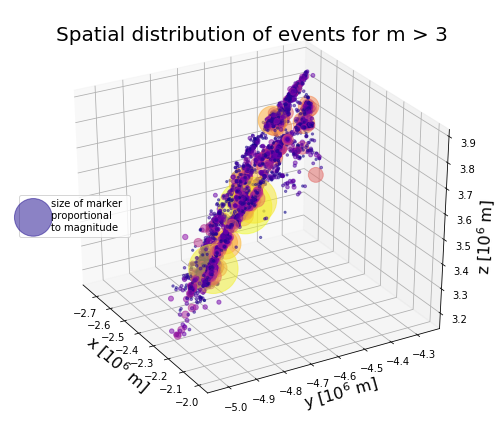

In [12]:
#az = [i*15 for i in range(24)]
#for azim in az:
%matplotlib nbagg
m_bar = 3
dfm = df[df['magnitude'] > m_bar]
x_coord = dfm['x']
y_coord = dfm['y']
z_coord = dfm['z']
magnitude = dfm['magnitude']

fig = plt.figure(figsize = (7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coord/1e06, y_coord/1e06, z_coord/1e06, 
           s=np.exp(magnitude*1.5)/np.exp(3), c = magnitude, marker="o", alpha = 0.5, 
           label = 'size of marker \nproportional \nto magnitude', cmap = 'plasma')
ax.set_xlabel("x [$10^6$ m]", fontsize = 16)
ax.set_ylabel("y [$10^6$ m]", fontsize = 16)
ax.set_zlabel("z [$10^6$ m]", fontsize = 16)
ax.set_title('Spatial distribution of events for m > 3', fontsize = 20)
ax.legend(loc = 'center left')
#print('azim = ', azim)
ax.view_init(elev = 30, azim = 330)
plt.tight_layout()
plt.show()

## PCA for spatial distribution

In [13]:
X = df[['x','y','z']].values.T
X = X.astype("float64")

# centering and rescaling the coordinates
for i in range(3):
    X[i] = (X[i] - X[i].mean())/X[i].std()

In [14]:
# PCA 
C = np.cov(X)
U, spectrum, Vt = la.svd(C)
print ('Spectrum: ', spectrum,'\n')
perc_expl2 = (spectrum[0] + spectrum[1]) / spectrum.sum()
print('Percent of the total variability explained considering the two main features: ', perc_expl2, '\n')

Spectrum:  [2.40189791e+00 5.96194962e-01 1.93433620e-03] 

Percent of the total variability explained considering the two main features:  0.9993552271146224 



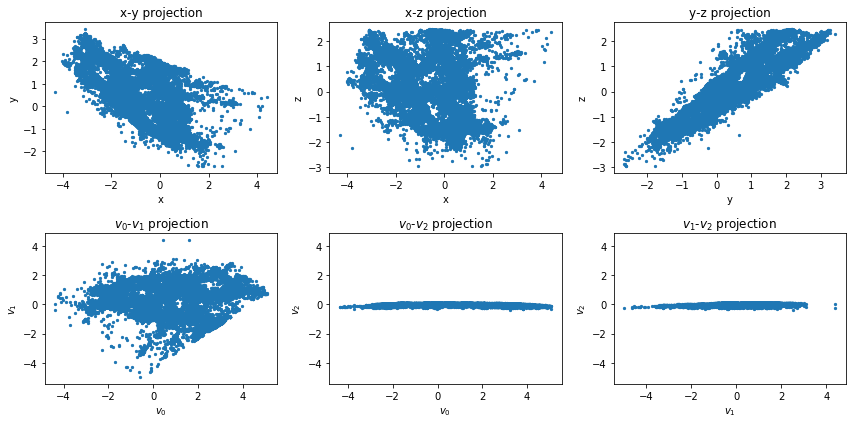

In [15]:
# projecting the data in the plane generated by the two eigenvectors with the largest eigenvalues
Xp = np.dot(Vt,X)

%matplotlib inline
# general plot of the PCA
fig, axes = plt.subplots(nrows=2, ncols=3,
                               figsize=(12, 6))

[[ax01, ax02, ax03],[ax11, ax12, ax13]] = axes

ax01.scatter(X[0], X[1], s= 5)
ax01.set_title('x-y projection')
ax01.set_xlabel('x')
ax01.set_ylabel('y')

ax02.scatter(X[0], X[2], s= 5)
ax02.set_title('x-z projection')
ax02.set_xlabel('x')
ax02.set_ylabel('z')

ax03.scatter(X[1], X[2], s= 5)
ax03.set_title('y-z projection')
ax03.set_xlabel('y')
ax03.set_ylabel('z')

ax11.scatter(Xp[0], Xp[1], s= 5)
ax11.set_title('$v_0$-$v_1$ projection')
(y_bottom, y_top) = ax11.get_ylim()
ax11.set_xlabel('$v_0$')
ax11.set_ylabel('$v_1$')

ax12.scatter(Xp[0], Xp[2], s= 5)
ax12.set_ylim(y_bottom, y_top)
ax12.set_title('$v_0$-$v_2$ projection')
ax12.set_xlabel('$v_0$')
ax12.set_ylabel('$v_2$')

ax13.scatter(Xp[1], Xp[2], s= 5)
ax13.set_ylim(y_bottom, y_top)
ax13.set_title('$v_1$-$v_2$ projection')
ax13.set_xlabel('$v_1$')
ax13.set_ylabel('$v_2$')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


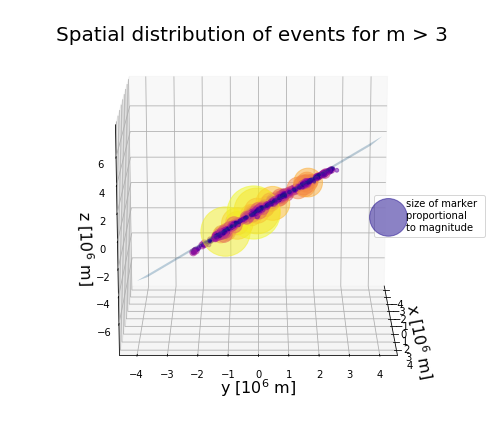

In [16]:
[v1, v2, v3] = Vt
normal = v3
xx, yy = np.meshgrid(range(-4,5), range(-4,5))# calculate corresponding z
z = (-normal[0] * xx - normal[1] * yy ) * 1. /normal[2]

m_bar = 3
dfm = df[df['magnitude'] > m_bar]
x_coord = dfm['x']
y_coord = dfm['y']
z_coord = dfm['z']
x_coord = (x_coord - x_coord.mean())/x_coord.std()
y_coord = (y_coord - y_coord.mean())/y_coord.std()
z_coord = (z_coord - z_coord.mean())/z_coord.std()
magnitude = dfm['magnitude']

%matplotlib nbagg

fig = plt.figure(figsize = (7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, z, alpha=0.3)
ax.scatter(x_coord, y_coord, z_coord, 
           s=np.exp(magnitude*1.5)/np.exp(3), c = magnitude, marker="o", alpha = 0.5, 
           label = 'size of marker \nproportional \nto magnitude', cmap = 'plasma')
ax.set_xlabel("x [$10^6$ m]", fontsize = 16)
ax.set_ylabel("y [$10^6$ m]", fontsize = 16)
ax.set_zlabel("z [$10^6$ m]", fontsize = 16)
ax.set_title('Spatial distribution of events for m > 3', fontsize = 20)
ax.legend(loc = 'center right')
#print('azim = ', azim)
ax.view_init(elev = 15, azim = 0)
plt.tight_layout()
plt.show()

In [17]:
plt.close()
%matplotlib inline

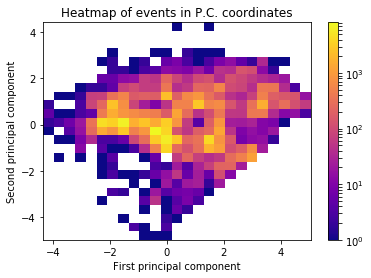

In [18]:
from matplotlib.colors import LogNorm
plt.figure(211)

# farlo in 3D con le barre?
plt.hist2d(Xp[0], Xp[1], bins = 25, norm = LogNorm(), cmap = "plasma")
plt.colorbar()
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Heatmap of events in P.C. coordinates')
plt.show()
plt.close()

# 2 - Distribution of waiting time 
Compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$.

In [19]:
#obsolete for the waiting times, still to be changed for the spatial distribution

def select_bin_number(x, m = 2, min_nbin = 7, fraction = 0.001):
    """Starts from evenly separed bins and merges the last ones until the tail's counts are 
        major or equal to the 'fraction' of the total number of occurrencies, given the 
        constraint that the final number of bins has to be min_nbin."""
    
    # added a factor exp(m-2) to take into account the exponential decrease of total N
    n_min = fraction*len(x)*np.exp(m-2)
    #n_min = fraction*len(x)
    
    n, bin_extremes, _ = plt.hist(x, bins = min_nbin )
    plt.close()
    last_n = n[-1]
    
    if last_n > n_min:
        return min_nbin, bin_extremes
    else:
        i = min_nbin 
        nbin = min_nbin
        while last_n < n_min and nbin < 100:
            nbin = nbin + 1
            n, _, _ = plt.hist(x, bins = nbin )
            plt.close()
            last_n = n[i-1:].sum()
            
        n, bin_extremes, _ = plt.hist(x, bins = nbin )
        plt.close()
        bins = np.concatenate((bin_extremes[:min_nbin],bin_extremes[-1:]))
        return nbin, bins

In [20]:
def select_bin_number_mod(x, m = 2, min_nbin = 7, fraction = 0.001):
    """Starts from evenly separed bins and merges the last ones until the tail's counts are 
        major or equal to the 'fraction' of the total number of occurrencies, given the 
        constraint that the final number of bins has to be min_nbin."""
    
    # added a factor exp(m-2) to take into account the exponential decrease of total N
    n_min = max([int(fraction*len(x)*np.exp(m-2)),10])
    print('For m = {} and N = {} the minimum number of events in the tail required is : {}'.format(m, len(x), n_min))
    print('Minimum accuracy expected : {}'.format(round(1 - 1/np.sqrt(n_min),2)))
    #n_min = fraction*len(x)
    
    n, bin_extremes, _ = plt.hist(x, bins = min_nbin )
    plt.close()
    last_n = n[-1]
    
    if last_n > n_min:
        return min_nbin, bin_extremes
    else:
        i = min_nbin 
        nbin = min_nbin
        while last_n < n_min and nbin < 100:
            nbin = nbin + 1
            n, _, _ = plt.hist(x, bins = nbin )
            plt.close()
            last_n = n[i-1:].sum()
        
        if last_n > n[min_nbin-2]:
            print('-> reducing the final number of bins to {}: \n'.format(min_nbin - 1))
            nbin, bins = select_bin_number_mod(x, m = m, min_nbin = min_nbin - 1)
        else:   
            n, bin_extremes, _ = plt.hist(x, bins = nbin )
            plt.close()
            bins = np.concatenate((bin_extremes[:min_nbin],bin_extremes[-1:]))
        
        return nbin, bins

In [21]:
def logP(t, A, B):
    return A + B*t

def logPmod(t, A, B, C):
    return A + B/t**C

def logt(t, p, q, r):
    return p*np.log(t*r) + q

def loglogt(t, p, q):
    return p*t + q

In [22]:
def plot_Pm_t2(m, df):
    print('\nTime distribution for m = ', m, '\n')
    # waiting time for events of magnitude > m
    dfm = df[df['magnitude'] > m]
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    #fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
    #ax1.plot(time_d)
    #ax1.axhline(time_d.mean()*2 + sigma_filter*time_d.std(), c = 'r')
    
    # eliminating a couple of anomalous events
    prova = time_d[time_d != time_d.max()]
    maximum = prova.max()
    if time_d.max()*3/4 > maximum:
        time_d = prova
    #time_d = time_d[mask]
    #print('Eliminated samples : ', len(timem) - len(time_d) -1, '\n')
    #ax2.plot(time_d)
    #plt.tight_layout()
    #plt.show()
    #plt.close()
    
    # time differences rescaled to [0,1]
    time_diff = time_d/time_d.max()
    
    
    # computing suitable sizes of bins
    original_bin_number, bins = select_bin_number_mod(time_diff, m = m)
    bin_number = len(bins) - 1
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
    
    n_tailed, bin_extremes, _  = ax1.hist(time_diff, bins = bins, histtype = 'step')
    
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    
    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    sigma_n = np.sqrt(n)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.')
    #, label = 'entries with \npoisson error'    #ax1.legend(loc = 'upper right')
    ax1.set_yscale('log')
    ax1.set_xlabel('normalized waiting times', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(time_diff)))
    
    # adding an inner plot of the relative accuracy (i.e. 1 - rel.err.) for the entries of the histogram
    ax3 = plt.axes([0.32, 0.55, 0.15, 0.25])
    accuracies = 1 - 1./np.sqrt(n)
    plt.plot(bin_centers, accuracies, 'g.')
    plt.title('Accuracy')
    plt.xlabel('bin labels')
    #plt.ylabel('accuracy')
    #plt.ylim(bottom = 0, top = 1)
    plt.setp(ax3, xticks = bin_centers, xticklabels =  [i+1 for i in range(len(bin_centers))])
    
    #print('Occurrencies for the first bin with {} original bins: '.format(bin_number), int(n[0]), '\n')
    print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')

    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    #n = np.concatenate((n[:-1], n[-1:]/(original_bin_number+1-bin_number)))
    
    # linear fit over the log of the entries
    params1, _ = optimize.curve_fit(loglogt, np.log(bin_centers), np.log(n), p0 = [-1,5])
    [p,q] = params1
    #print('p = {}\nq = {}'.format(round(p,2), round(q,2)))
    
    # chi squared and p-value tests
    #chisq, pv = chisquare(np.log(n), loglogt(np.log(bin_centers), *params1), ddof = 2 )
    
    y_errors = 1./np.sqrt(n)
    ax2.errorbar(np.log(bin_centers), np.log(n), yerr = y_errors ,fmt ='r.', label = 'entries with errors')
    ax2.plot(np.log(bin_centers), loglogt(np.log(bin_centers), *params1), 
             label = 'f(x) = px + q\np = {} \nq = {}'.format(round(params1[0],1),round(params1[1],1)))
             #label = 'p = {} \nq = {}\n$\chi^2$ = {} \np-value = {}'\
             #.format(round(params1[0],1),round(params1[1],1),round(chisq,2),round(pv,2)))
    ax2.legend()
    ax2.set_xlabel('normalized waiting times [logscale]', fontsize = 14)
    ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)
    
    # Finally we can plot in the first panel the obtained fit:
    x_axis = np.linspace(bin_centers[0], bin_extremes[-1], 100)
    #print(ax1)
    ax1.plot(x_axis, np.exp(p*np.log(x_axis)+q))

    plt.show()
    plt.close()
    
    return p, q

In [23]:
#help(plt.axes)


Time distribution for m =  2.0 

For m = 2.0 and N = 106196 the minimum number of events in the tail required is : 106
Minimum accuracy expected : 0.9
Number of bins merged into the tail: 5 



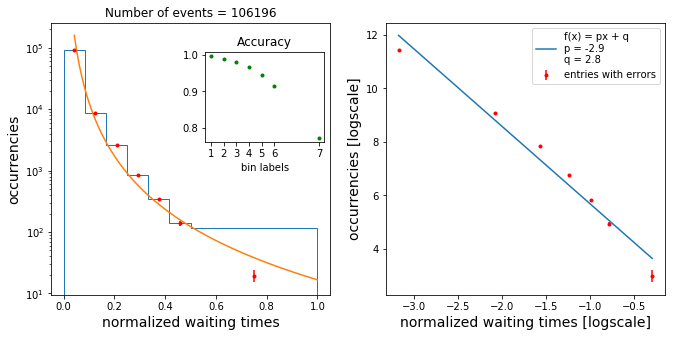


Time distribution for m =  2.5 

For m = 2.5 and N = 37620 the minimum number of events in the tail required is : 62
Minimum accuracy expected : 0.87
Number of bins merged into the tail: 7 



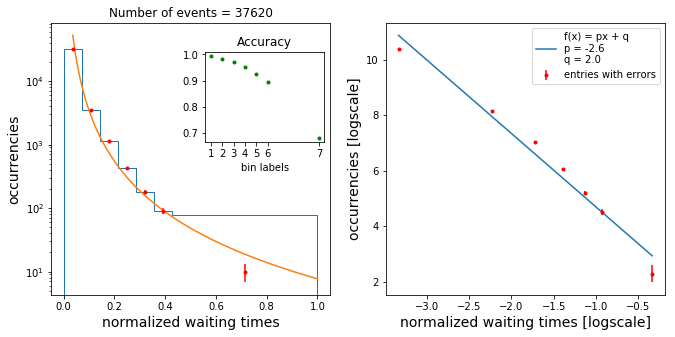


Time distribution for m =  3.0 

For m = 3.0 and N = 11457 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82
Number of bins merged into the tail: 5 



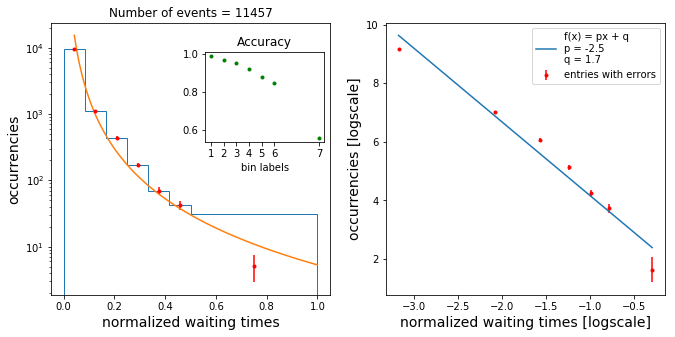


Time distribution for m =  3.5 

For m = 3.5 and N = 3526 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
-> reducing the final number of bins to 6: 

For m = 3.5 and N = 3526 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
Number of bins merged into the tail: 4 



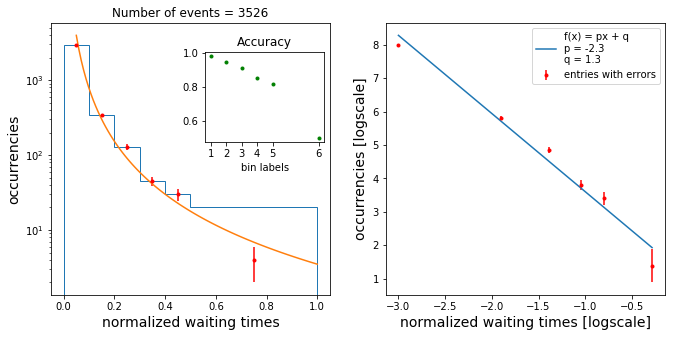


Time distribution for m =  4.0 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 2 



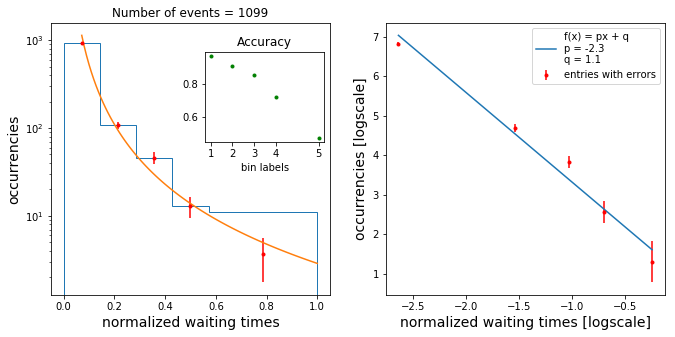


Time distribution for m =  4.5 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 4: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 3 



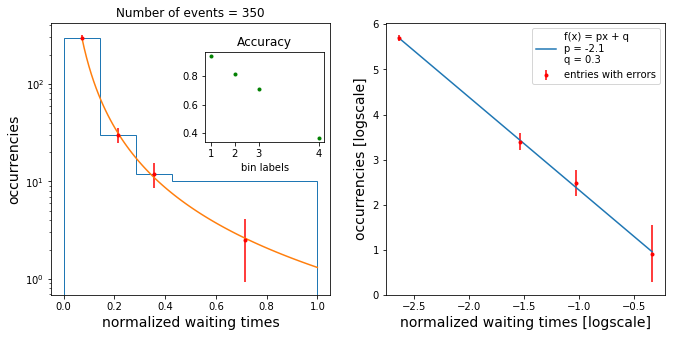

In [24]:
# we choose to study the data for m between 2 and 4.5, because above 5 we get just 104 samples 
# and there isn't enough information to fit anything but the initial peak of the distribution.

ms = np.linspace(2,4.5,6)
ps1 = np.zeros(len(ms))
qs1 = np.zeros(len(ms))
#chis1 = np.zeros(len(ms))
#pvs1 = np.zeros(len(ms))

for i in range(len(ms)):
    m = ms[i]
    ps1[i], qs1[i] = plot_Pm_t2(m, df)

### Scaling of the exponent as a function of m

Distribution considered:

$P_{m>\bar{m}}(t_w) = At_w^{-\alpha(\bar{m})}$,

where $\alpha = -p$ and A is just a normalization constant.

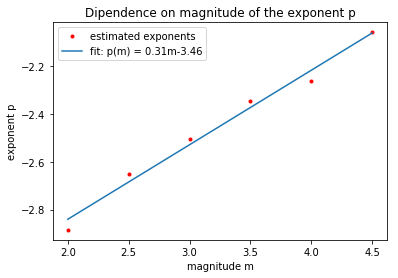

In [25]:
# we can see how the exponent is a linear funcion of m

slope, intercept, r_value, p_value, std_err = stats.linregress(ms, ps1)
plt.plot(ms, ps1, '.r', label = 'estimated exponents' )
plt.plot(ms, intercept+slope*ms, label = 'fit: p(m) = %.2fm%.2f'%(slope,intercept))
plt.title('Dipendence on magnitude of the exponent p')
plt.ylabel('exponent p')
plt.xlabel('magnitude m')
plt.legend()
plt.show()

# 3 - Distance distribution between events

Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude m or above. Also here make a clever choice for the bin sizes and try several values of $m$.

In [61]:
def plot_Pm_r2(m, df):
    print('\nDistance distribution for m = ', m, '\n')
    dfm = df[df['magnitude'] > m]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    r_norm = r/r.max()
    
    
    # computing suitable sizes of bins
    original_bin_number, bins = select_bin_number_mod(r_norm, m=m, min_nbin = 10)
    
    bin_number = len(bins) - 1
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
    
    n_tailed, bin_extremes, _  = ax1.hist(r_norm, bins = bins, histtype = 'step')
    
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    
    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    
    sigma_n = np.sqrt(n)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.')
    #, label = 'entries with \npoisson error'    #ax1.legend(loc = 'upper right')
    ax1.set_yscale('log')
    ax1.set_xlabel('normalized distances', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(r_norm)))
  
    print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')

    # linear fit over the log of the entries
    params1, _ = optimize.curve_fit(logP, bin_centers, np.log(n), p0 = [np.log(n[0]),-1])
    [A,B] = params1
    print('A = {}\nB = {}'.format(round(A,2), round(B,2)))
    
    y_errors = 1./np.sqrt(n)
    ax2.errorbar(bin_centers, np.log(n), yerr = y_errors ,fmt ='r.', label = 'entries with errors')
    ax2.plot(bin_centers, logP(bin_centers, *params1), 
             label = 'A = {} \nB = {}'.format(round(params1[0],1),round(params1[1],1)))
    ax2.set_xlabel('normalized distances', fontsize = 14)
    ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)
    ax2.legend()
    
    # Finally we can plot in the first panel the obtained fit:
    x_axis = np.linspace(bin_centers[0], bin_extremes[-1], 100)
    #print(ax1)
    ax1.plot(x_axis, np.exp(A+B*x_axis))

    plt.show()
    plt.close()
    
    return A, B, r.mean(), r.std()/np.sqrt(len(r))


Distance distribution for m =  2.0 

For m = 2.0 and N = 106197 the minimum number of events in the tail required is : 106
Minimum accuracy expected : 0.9
Number of bins merged into the tail: 1 

A = 11.16
B = -6.33


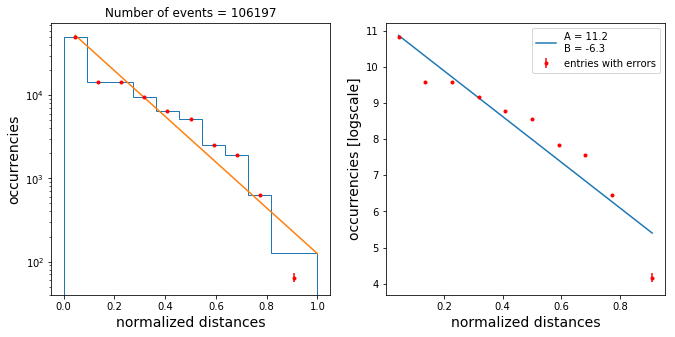


Distance distribution for m =  2.5 

For m = 2.5 and N = 37621 the minimum number of events in the tail required is : 62
Minimum accuracy expected : 0.87
Number of bins merged into the tail: 1 

A = 9.68
B = -4.81


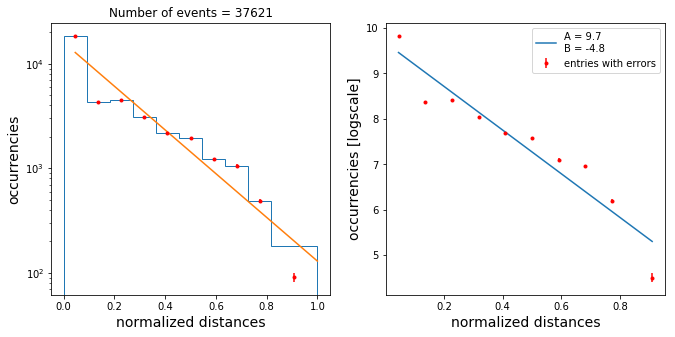


Distance distribution for m =  3.0 

For m = 3.0 and N = 11457 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82
Number of bins merged into the tail: 2 

A = 8.5
B = -5.39


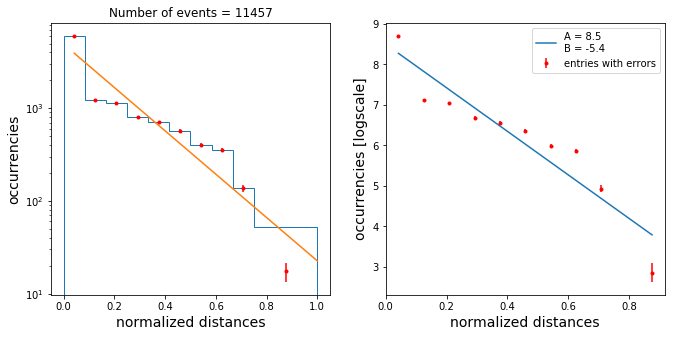


Distance distribution for m =  3.5 

For m = 3.5 and N = 3526 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74
Number of bins merged into the tail: 2 

A = 7.2
B = -4.98


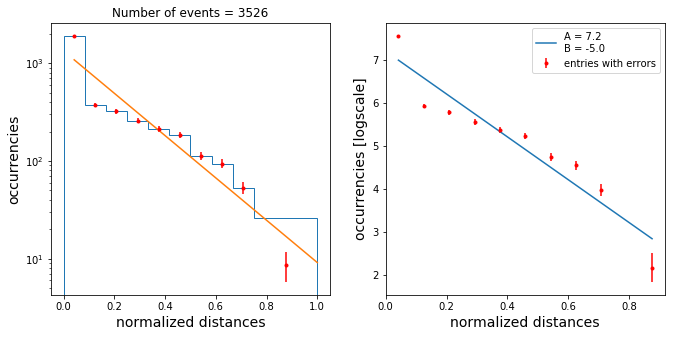


Distance distribution for m =  4.0 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 3 

A = 5.97
B = -5.13


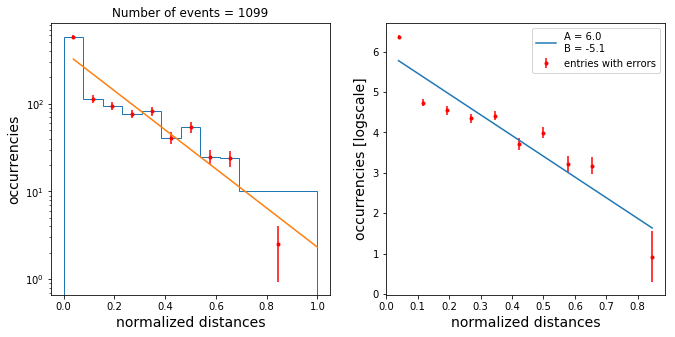


Distance distribution for m =  4.5 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 9: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 8: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 7: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 1 

A = 5.

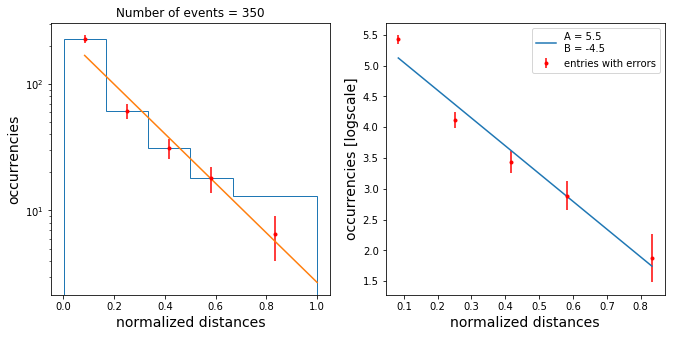

In [57]:
ms = np.linspace(2,4.5,6)

ps_r = np.zeros(len(ms))
qs_r = np.zeros(len(ms))
r_mean = np.zeros(len(ms))
r_std = np.zeros(len(ms))

for i in range(len(ms)):
    m = ms[i]
    ps_r[i], qs_r[i], r_mean[i], r_std[i] = plot_Pm_r2(m, df)

Given the difficulty in understanding the spatial distribution of the events, we started to analyze all the factor that can influence the distance between two events.

First of all we compared the mean distance considering two ensambles:
* the one in which we consider all events and we compute for each one the distance with the event with the next ID number
* the one in which we consider only prime events (that in some sense can be thought as independent and thus randomly distributed)

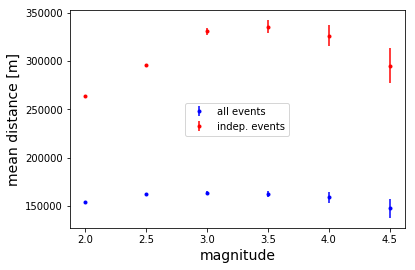

In [60]:
# Mean distance between only prime events is larger than the one obtained considering all events

r_indep_events = []
r_indep_std = []
for i in range(len(ms)):
    dfm = df[(df['magnitude'] > ms[i]) & (df['prev_event'] == -1)]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    r_indep_events.append(r.mean())
    r_indep_std.append(r.std()/np.sqrt(len(r)))
    
plt.errorbar(ms, r_mean, yerr = r_std, fmt = 'b.', label = 'all events')
plt.errorbar(ms, r_indep_events, yerr = r_indep_std, fmt = 'r.', label = 'indep. events')
plt.legend(loc = 'center')
plt.xlabel('magnitude', fontsize = 14)
plt.ylabel('mean distance [m]', fontsize = 14)
plt.show()

## 3.1 - Range-conditioned distance distribution

Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. (In this statistics, if the following event is farther than $R$, skip the $t$ and go to the next pair)

In [76]:
#def plot_Pm_t_Rcond1(m, R_fractions, df):


In [75]:
# Function to plot waiting times with R condition (fixed m_min)

from scipy import optimize
from scipy.stats import chisquare

def plot_Pm_t_Rcondition(m, R_fractions, df, sigma_filter = 10):
    #print('m = ', m, '\n')
    
    # distance and waiting times between events of magnitude > m
    dfm = df[df['magnitude'] > m]
    dfm = dfm.set_index(np.arange(len(dfm)))
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    #vector for fit parameters for each R_max fraction
    As = []
    Bs = []
    Cs = []
    chis = []
    ps = []
    
    #Repeat plots and fits for each R_max fraction
    for i in range(1, R_fractions+1):
        # building the mask to filter "distances < R" and apply that to original waiting times
        print("R_max = "+str(i)+"/"+str(R_fractions)+" * max_distance")
        R_mask = pd.Series(np.concatenate((np.array([True]), r <= i/R_fractions*r.max())))
        dfmr = dfm[R_mask]
        r_norm = r[R_mask[1:]]/r.max()  
        time_diff = time_d[R_mask[1:]]/time_d.max()
        print("Sono stati rimossi {} eventi ({}%)\n"\
              .format(len(dfm)-len(dfmr), round(100*(1-(len(dfmr)/len(dfm))))))
 
        # computing suitable sizes of bins
        bin_number, bins = select_bin_number(time_diff)

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

        n, bin_extremes, _  = ax1.hist(time_diff, bins = bins, histtype = 'step')

        bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
        sigma_n = np.sqrt(n)
        ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.', label = 'entries with \npoisson error')
        ax1.legend(loc = 'upper right')
        ax1.set_yscale('log')

        print('Occurrencies for the first bin with {} original bins: '.format(bin_number), n[0], '\n')

        # rescaling the tail entries with the number of bins merged into the tail
        n = np.concatenate((n[:-1], n[-1:]/(bin_number+1-7)))
        # linear fit over the log of the entries
        #params1, _ = optimize.curve_fit(logP, bin_centers, np.log(n), p0 = [np.log(n[0]),-1])
        params1, _ = optimize.curve_fit(loglogt, bin_centers, np.log(n), p0 = [-1,5])
        [A,B] = params1
        print('A = {}\nB = {}\n'.format(round(A,2), round(B,2)))

        # chi squared and p-value tests
        chisq, p = chisquare(np.log(n), loglogt(bin_centers, *params1), ddof = 2 )

        ax2.plot(bin_centers, np.log(n), 'r.', label = 'entries')
        ax2.plot(bin_centers, loglogt(bin_centers, *params1), 
                 label = 'A = {} \nB = {}\n$\chi^2$ = {} \np-value = {}'\
                 .format(round(params1[0],1),round(params1[1],1),round(chisq,2),round(p,2)))
        ax2.legend()

        plt.show()
        plt.close()

        gridsize = (2, 3)
        fig = plt.figure(figsize=(10, 4))
        ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
        ax1.plot(time_diff)

        ax2 = plt.subplot2grid(gridsize, (0, 2), colspan = 1, rowspan = 2)
        n2, bins2, patches2 = ax2.hist(time_diff, bins = bins, orientation = 'horizontal', color = 'skyblue')
        #hist_with_kde(ax2, time_diff, bins = bins, histtype = 'step', orientation = 'horizontal')
        ax2.set_xscale('log')
        ax2.axis('off')
        plt.show()
        plt.close()

        #Add parameters in their lists
        As.append(A)
        Bs.append(B)
        #Cs.append(C)
        chis.append(chisq)
        ps.append(p)
        
    return As, Bs, chis, ps

R_max = 1/10 * max_distance
Sono stati rimossi 5126 eventi (45%)

Occurrencies for the first bin with 9 original bins:  5856.0 

A = -14.74
B = 7.76



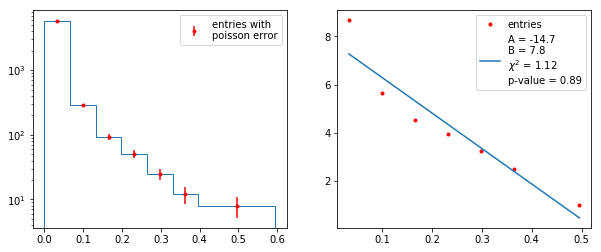

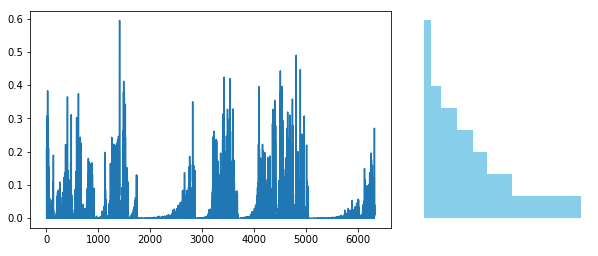

R_max = 2/10 * max_distance
Sono stati rimossi 3696 eventi (32%)

Occurrencies for the first bin with 11 original bins:  7024.0 

A = -12.04
B = 8.02



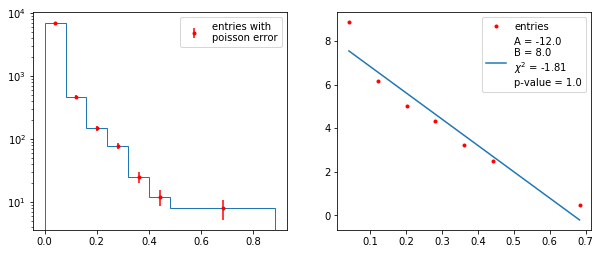

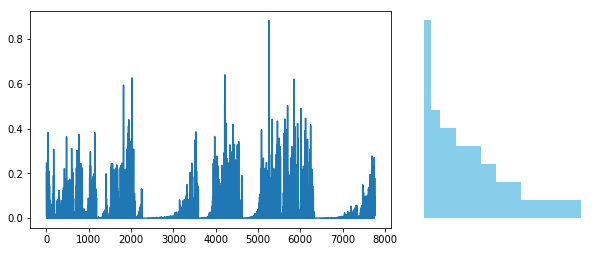

R_max = 3/10 * max_distance
Sono stati rimossi 2517 eventi (22%)

Occurrencies for the first bin with 11 original bins:  7842.0 

A = -11.4
B = 8.27



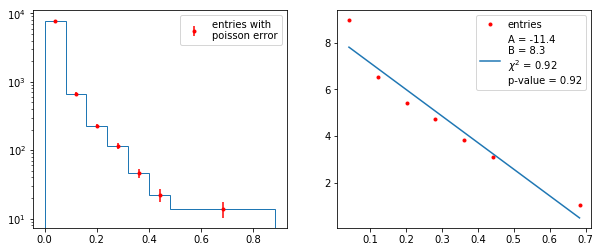

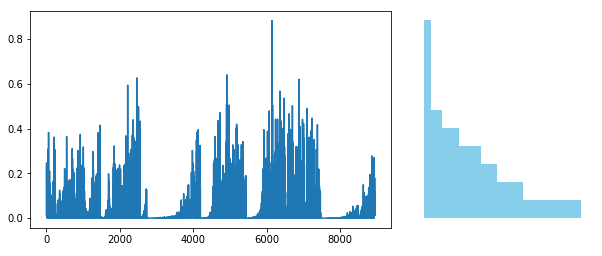

R_max = 4/10 * max_distance
Sono stati rimossi 1652 eventi (14%)

Occurrencies for the first bin with 10 original bins:  8558.0 

A = -11.34
B = 8.57



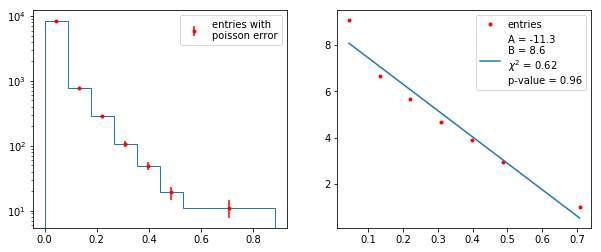

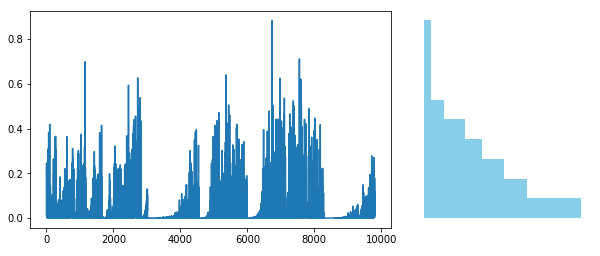

R_max = 5/10 * max_distance
Sono stati rimossi 943 eventi (8%)

Occurrencies for the first bin with 10 original bins:  9220.0 

A = -10.27
B = 8.6



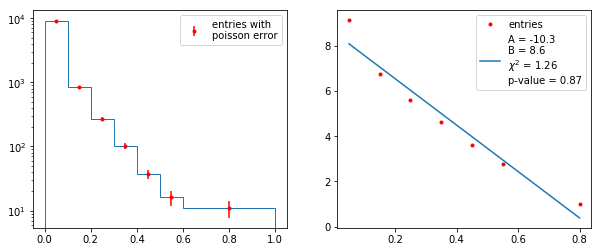

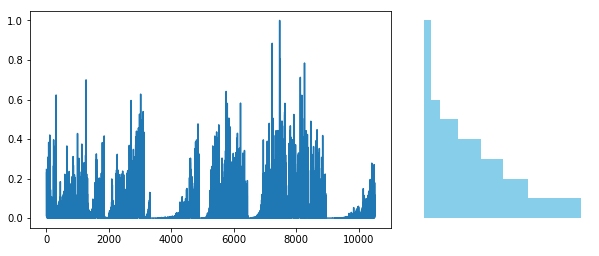

R_max = 6/10 * max_distance
Sono stati rimossi 463 eventi (4%)

Occurrencies for the first bin with 10 original bins:  9564.0 

A = -10.18
B = 8.68



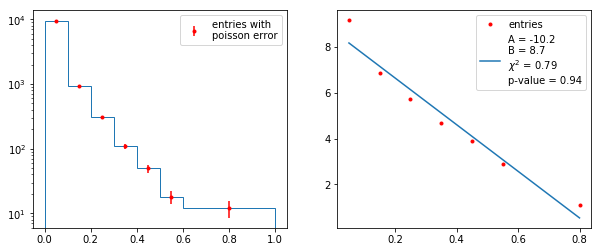

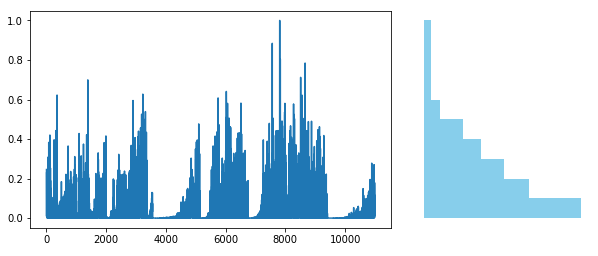

R_max = 7/10 * max_distance
Sono stati rimossi 117 eventi (1%)

Occurrencies for the first bin with 10 original bins:  9824.0 

A = -10.22
B = 8.74



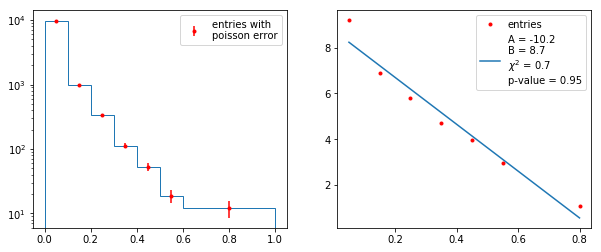

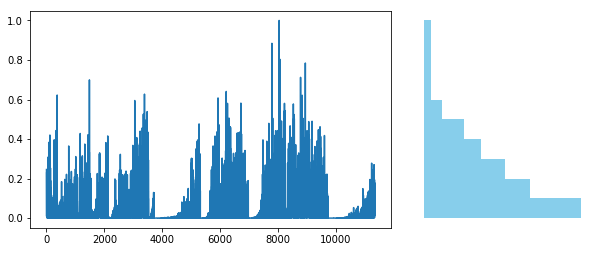

R_max = 8/10 * max_distance
Sono stati rimossi 18 eventi (0%)

Occurrencies for the first bin with 10 original bins:  9894.0 

A = -10.25
B = 8.76



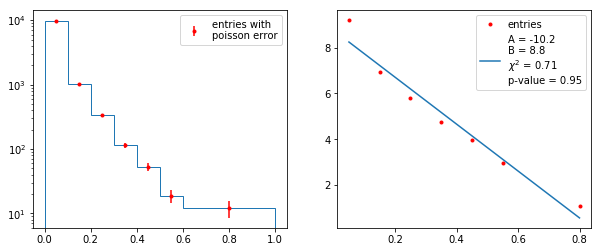

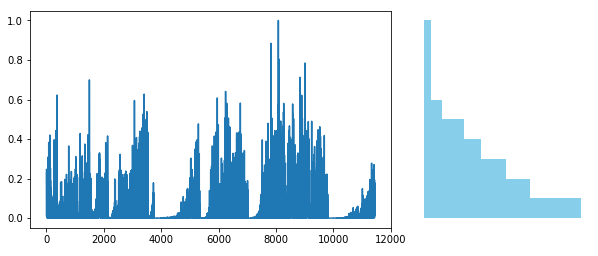

R_max = 9/10 * max_distance
Sono stati rimossi 5 eventi (0%)

Occurrencies for the first bin with 10 original bins:  9904.0 

A = -10.25
B = 8.76



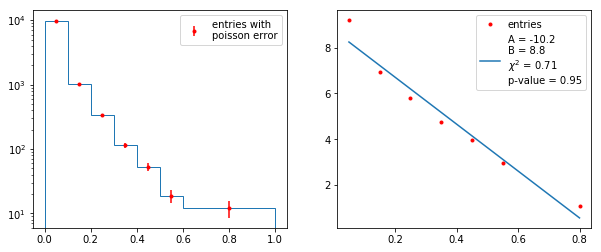

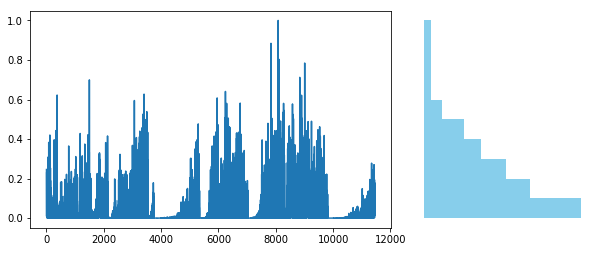

R_max = 10/10 * max_distance
Sono stati rimossi 0 eventi (0%)

Occurrencies for the first bin with 10 original bins:  9908.0 

A = -10.25
B = 8.76



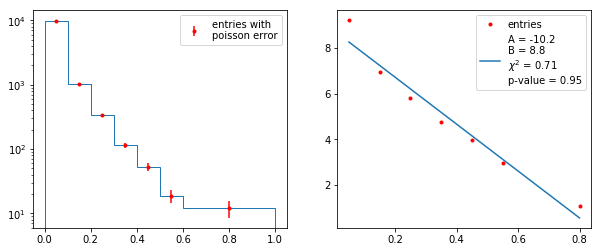

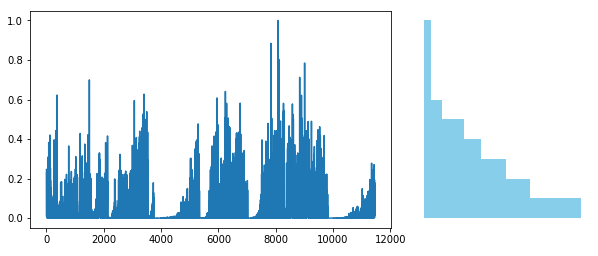

In [72]:
# Rifare plot cambiando funzione da fittare (non retta)
As, Bs, chis, ps = plot_Pm_t_Rcondition(3,10,df)

p = 0.47
q = 8.92
t = 0.9



/home/nicola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


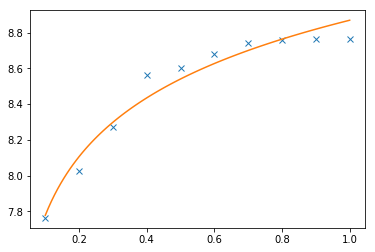

In [73]:
# Plot di B in funzione del raggio limite (waiting times minori per R bassi perchè decresce di più)
plt.plot(np.linspace(0.1,1,10), Bs, 'x') # R_lim dato come frazione di R_max
params_Bs, _ = optimize.curve_fit(logt, np.linspace(0.1,1,10), Bs)
print('p = {}\nq = {}\nt = {}\n'.format(round(params_Bs[0],2), round(params_Bs[1],2), round(params_Bs[2],2)))
plt.plot(np.linspace(0.1,1,100), logt(np.linspace(0.1,1,100), *params_Bs))
plt.show()

p = 1.84
q = -14.45
t = 13.65



/home/nicola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


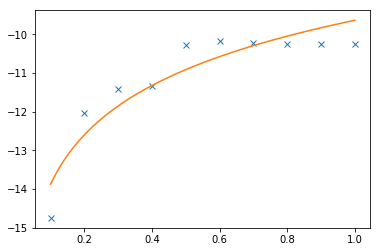

In [74]:
# Plot di A in funzione del raggio massimo
plt.plot(np.linspace(0.1,1,10), As, 'x')
params_As, _ = optimize.curve_fit(logt, np.linspace(0.1,1,10), As)
print('p = {}\nq = {}\nt = {}\n'.format(round(params_As[0],2), round(params_As[1],2), round(params_As[2],2)))
plt.plot(np.linspace(0.1,1,100), logt(np.linspace(0.1,1,100), *params_As))
plt.show()

## Waiting time distribution between concatenated events

We now analyze the same distribution but considering only the waiting times between an event and the ancestor.


In general we expect a greater exponent $\alpha$ of $P_{m>\bar{m}}(t_w) = At_w^{-\alpha(\bar{m})}$ because we consider much more correlated pairs of event than in the previous case.

### Tree architecture
First of all we iteratively created a nested dictionary, containing as keys the IDs of the primes events (i.e. the ones labelled with 'prev_event' = 1) and as values a dictionary with:
* the "depth" of the event in the cause-effect chain (i.e. 0 for the prime events, 1 for the ones caused by them, 2 for the ones caused by events of depth 1 and so on so forth);
* the "children" of that event, i.e. the events that have as prev_event the id of the event considered; "children" value contains itself a dictionary like the one just described for the prime events, hence the nested structure.

In [62]:
def evees_light(df, index=-1, depth=0):
    dataset = {}
    df_filtered = df[df["prev_event"]==index]
    lenght =  df_filtered.shape[0]
    for i in range(lenght):
        event = df_filtered.iloc[i]
        dataset[str(int(event["event"]))] = {"depth" : depth}
        dataset[str(int(event["event"]))]["children"] = evees_light(df, index=int(event["event"]), depth = depth + 1)
    return dataset

Then we mapped the dictionary so obtained in a list of dictionaries, whose indexes are the depth of the events (ranging from 0 to max_depth, that is unknown a priori); the entry of the list of index i is a dictionary that has as keys the IDs of the events of depth = i and as values the IDs of its children.

In [63]:
def write_dict_array(dataset, dict_array):
    for k in dataset.keys():
        depth = dataset[k]['depth']
        # k is the keyword, children_ids are the values
        if len(dict_array) < depth + 1 :
            while len(dict_array) < depth + 1:
                dict_array.append({})
        else:
            dict_array[depth][k] = list(dataset[k]['children'].keys())
        if len(list(dataset[k]['children'].keys())) != 0:
            write_dict_array(dataset[k]['children'], dict_array)

In [64]:
tree_dataset = evees_light(df)
v_dict = [{}]
write_dict_array(tree_dataset, v_dict)

Now we use the list of dictionaries to add the depth and the number of children (or number of edges if we think of the dataset as an oriented graph) of each event by adding two columns to the original dataset.

In [65]:
N = df.shape[0]
edges = np.zeros(N)
depths = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        #print(k)
        edges[int(k)] = len(v_dict[d][k])
        depths[int(k)] = d
        
df['edges'] = edges
df['depth'] = depths

In [66]:
# From the new features we can see an interesting thing: the event with the highest magnitude (7.3) is not prime 
# (because it hasn't prev_event = -1), but it happend after a concatenation of 11 earthquakes and subsequently caused 
# other 4209 events!
df[df['magnitude'] == 7.3]

,event,prev_event,time,magnitude,x,y,z,edges,depth
39805,39805,39804,3.309144e+08,7.3,-2341818,-4710335,3575181,4209.0,11.0


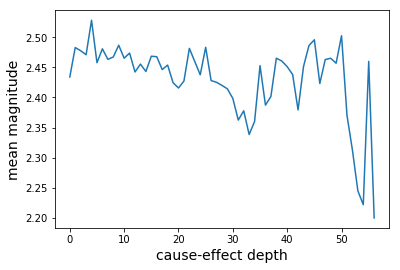

In [67]:
# Furthermore we can see that depth isn't a good indicator of magnitude and that in fact one can't find any relation
# between the two
mean_mag = df.groupby('depth')['magnitude'].mean()
depth_axis = [i for i in range(len(mean_mag))]
plt.plot(depth_axis, mean_mag)
plt.xlabel('cause-effect depth', fontsize = 14)
plt.ylabel('mean magnitude', fontsize = 14)
plt.show()

Now we compute the waiting time between each event and his previous event. Thus prime events don't have a waiting time in this analysis.

In [68]:
time_diff_tree = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        # previous vertex has id = k, children vertexes have ids [ v_dict[d][k] ]
        for j in v_dict[d][k]:
            #print('Computing {}-> {} waiting time.'.format(k,j))
            time_diff_tree[int(j)] = df['time'].iloc[int(j)] - df['time'].iloc[int(k)]
            
time_diff_tree = time_diff_tree[time_diff_tree > 0]

In [69]:
def plot_Pm_t_tree(time_d, m = 2):
    # time differences rescaled to [0,1]
    time_diff = time_d/time_d.max() 
    
    # computing suitable sizes of bins
    original_bin_number, bins = select_bin_number_mod(time_diff, m = m)
    bin_number = len(bins) - 1
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
    
    n_tailed, bin_extremes, _  = ax1.hist(time_diff, bins = bins, histtype = 'step')
    
    n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    sigma_n = np.sqrt(n)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.')
    #, label = 'entries with \npoisson error'    #ax1.legend(loc = 'upper right')
    ax1.set_yscale('log')
    ax1.set_xlabel('normalized waiting times', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(time_diff)))
    
    # adding an inner plot of the relative accuracy (i.e. 1 - rel.err.) for the entries of the histogram
    ax3 = plt.axes([0.32, 0.55, 0.15, 0.25])
    accuracies = 1 - 1./np.sqrt(n)
    plt.plot(bin_centers, accuracies, 'g.')
    plt.title('Accuracy')
    plt.xlabel('bin labels')
    #plt.ylabel('accuracy')
    #plt.ylim(bottom = 0, top = 1)
    plt.setp(ax3, xticks = bin_centers, xticklabels =  [i+1 for i in range(len(bin_centers))])
    
    #print('Occurrencies for the first bin with {} original bins: '.format(bin_number), int(n[0]), '\n')
    print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')

    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    #n = np.concatenate((n[:-1], n[-1:]/(original_bin_number+1-bin_number)))
    # linear fit over the log of the entries
    params1, _ = optimize.curve_fit(loglogt, np.log(bin_centers), np.log(n), p0 = [-1,5])
    [p,q] = params1
    #print('p = {}\nq = {}'.format(round(p,2), round(q,2)))
    
    # chi squared and p-value tests
    #chisq, pv = chisquare(np.log(n), loglogt(np.log(bin_centers), *params1), ddof = 2 )
    
    y_errors = 1./np.sqrt(n)
    ax2.errorbar(np.log(bin_centers), np.log(n), yerr = y_errors ,fmt ='r.', label = 'entries with errors')
    ax2.plot(np.log(bin_centers), loglogt(np.log(bin_centers), *params1), 
             label = 'f(x) = px + q\np = {} \nq = {}'.format(round(params1[0],1),round(params1[1],1)))
             #label = 'p = {} \nq = {}\n$\chi^2$ = {} \np-value = {}'\
             #.format(round(params1[0],1),round(params1[1],1),round(chisq,2),round(pv,2)))
    ax2.legend()
    ax2.set_xlabel('normalized waiting times [logscale]', fontsize = 14)
    ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)
    
    # Finally we can plot in the first panel the obtained fit:
    x_axis = np.linspace(bin_centers[0], bin_extremes[-1], 100)
    #print(ax1)
    ax1.plot(x_axis, np.exp(p*np.log(x_axis)+q))
    
    plt.show()
    plt.close()
    
    return p, q

For m = 2 and N = 71481 the minimum number of events in the tail required is : 71
Minimum accuracy expected : 0.88
-> reducing the final number of bins to 6: 

For m = 2 and N = 71481 the minimum number of events in the tail required is : 71
Minimum accuracy expected : 0.88
-> reducing the final number of bins to 5: 

For m = 2 and N = 71481 the minimum number of events in the tail required is : 71
Minimum accuracy expected : 0.88
Number of bins merged into the tail: 4 



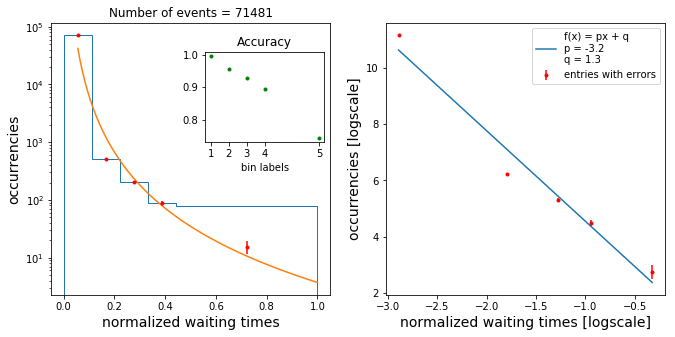

In [70]:
p_tree, q_tree = plot_Pm_t_tree(time_diff_tree )